In [71]:
from keras.layers import Dense, Activation, Dropout, SpatialDropout1D, Embedding, LSTM
from keras.models import Sequential
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kubra\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [72]:
DATA = 'original_train_data.txt'

In [73]:
maxlen = 0
word_freqs = collections.Counter()
num_recs = 0
ftrain = open(DATA, 'rb')
for line in ftrain:
    label, sentence = line.strip().split(b'\t')
    words = nltk.word_tokenize(sentence.decode('ascii', 'ignore').lower())
    if len(words) > maxlen:
        maxlen = len(words)
    for word in words:
        word_freqs[word] += 1
    num_recs += 1
ftrain.close()

In [74]:
MAX_FEATURES = 2000
MAX_SENTENCE_LENGHT = 40

In [75]:
vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
word2index = {x[0]: i+2 for i, x in enumerate(word_freqs.most_common(MAX_FEATURES))}
word2index['PAD'] = 0
word2index['UNK'] = 1
index2word = {v: k for k, v in word2index.items()}

In [76]:
X = np.empty((num_recs, ), dtype=list)
y = np.zeros((num_recs, ))
i = 0
ftrain = open(DATA, 'rb')
for line in ftrain:
    label, sentence = line.strip().split(b'\t')
    words = nltk.word_tokenize(sentence.decode('ascii', 'ignore').lower())
    seqs = []
    for word in words:
        if word2index.__contains__(word):
            seqs.append(word2index[word])
        else:
            seqs.append(word2index['UNK'])
    X[i] = seqs
    y[i] = int(label)
    i += 1
ftrain.close()
X = sequence.pad_sequences(X, maxlen=MAX_SENTENCE_LENGHT)

In [77]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [118]:
EMBEDDING_SIZE = 128
HIDDEN_LAYER_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 10

In [119]:
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_SIZE))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1))
model.add(Activation('sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [120]:
history = model.fit(Xtrain, ytrain, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, validation_data=(Xtest, ytest))

Epoch 1/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7776 - loss: 0.4166 - val_accuracy: 0.9757 - val_loss: 0.0582
Epoch 2/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9920 - loss: 0.0275 - val_accuracy: 0.9868 - val_loss: 0.0384
Epoch 3/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9944 - loss: 0.0216 - val_accuracy: 0.9868 - val_loss: 0.0415
Epoch 4/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9991 - loss: 0.0045 - val_accuracy: 0.9889 - val_loss: 0.0401
Epoch 5/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9982 - loss: 0.0068 - val_accuracy: 0.9882 - val_loss: 0.0405
Epoch 6/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9997 - loss: 0.0013 - val_accuracy: 0.9882 - val_loss: 0.0435
Epoch 7/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.9992 - loss: 0.0025 - val_accuracy: 0.9896 - val_loss: 0.0502
Epoch 8/10
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9995 - loss: 0.0012 - val_accuracy: 0.

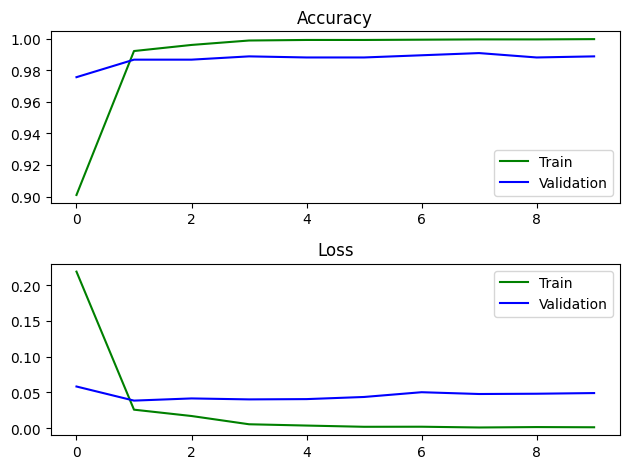

In [121]:
plt.subplot(211)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], color='g', label='Train')
plt.plot(history.history['val_accuracy'], color='b', label='Validation')
plt.legend(loc='best')
plt.subplot(212)
plt.title('Loss')
plt.plot(history.history['loss'], color='g', label='Train')
plt.plot(history.history['val_loss'], color='b', label='Validation')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [133]:
score, acc = model.evaluate(Xtest, ytest, batch_size=BATCH_SIZE)
print('Test score: %.3f, accuracy: %.3f' % (score, acc))
threshold = 0.5
for i in range(5):
    idx = np.random.randint(len(Xtest))
    xtest = Xtest[idx].reshape(1, 40)
    ylabel = ytest[idx]
    ypred = model.predict(xtest)[0][0]
    ypred = np.where(ypred > threshold, 1,0)
    sent = ' '.join([index2word[x] for x in xtest[0].tolist() if x != 0])
    print(f'{ypred} <--*--> {ylabel} <--*--> {sent}')

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9910 - loss: 0.0395 
Test score: 0.049, accuracy: 0.989
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1 <--*--> 1 <--*--> the da vinci code was absolutely awesome !
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
0 <--*--> 0 <--*--> da vinci code = up , up , down , down , left , right , left , right , b , a , suck !
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
0 <--*--> 0 <--*--> harry potter dragged draco malfoy s trousers down past his hips and sucked him into his throat with vigor , making whimpering noises and panting and groaning around the blonds rock-hard , aching cock ...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1 <--*--> 1 <--*--> harry potter is awesome i do n't care if anyone says differently ! ..
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1 <--*--> 1 <--*--> the story of harry potter is a deep and profound one , and i love harry potter .
